# Linear Regression in statsmodels (Practice)

**Task:** Run a linear regression with statsmodels predict the price of a car.

**Data:** https://www.kaggle.com/datasets/hellbuoy/car-price-prediction

**Steps to perform:**

- Perform initial preprocessing of data
- Perform preprocessing for statsmodels
- Run the model in statsmodels and produce a results summary
- Evaluate the model on the test set
- In a markdown cell below your results, summarize what assumptions the model did and/or did not meet
- If you model did not meet the assumptions, then iterate on the model and add/change any preprocessing needed to improve its performance

# 1. Preliminary Steps

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score, mean_squared_error
np.random.seed(321)
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
plt.rcParams['figure.facecolor'] = 'white'
plt.style.use(['seaborn-talk'])
import joblib

C:\Users\yang0108\AppData\Local\Temp\ipykernel_14180\889729579.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-talk'])


In [2]:
# load data
df = pd.read_csv('Data/CarPrice_Assignment.csv')

# check
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


**Target:** The model we build will be used to predict the price of the cars.

In [3]:
# check for null values
df.isna().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [4]:
# renaming categorical variable 'symboling' according to data dictionary
symboling_map = {-3: "safest",
                -2: "safer",
                -1: "safe",
                0: "neutral",
                1: "risky",
                2: "riskier",
                3: "riskiest"}

df['symboling'] = df['symboling'].replace(symboling_map)

# check
df['symboling'].value_counts()

neutral     67
risky       54
riskier     32
riskiest    27
safe        22
safer        3
Name: symboling, dtype: int64

# 2. Model Assumptions (Part 1)

## 2.1 Assumption of Linearity

The linear regression model assumes that the features in the model have a linear relationship with the target.

In [5]:
# select numeric columns
num_selector = make_column_selector(dtype_include = 'number')
cols = num_selector(df.drop(columns = ['price', 'car_ID']))
len(cols)

13

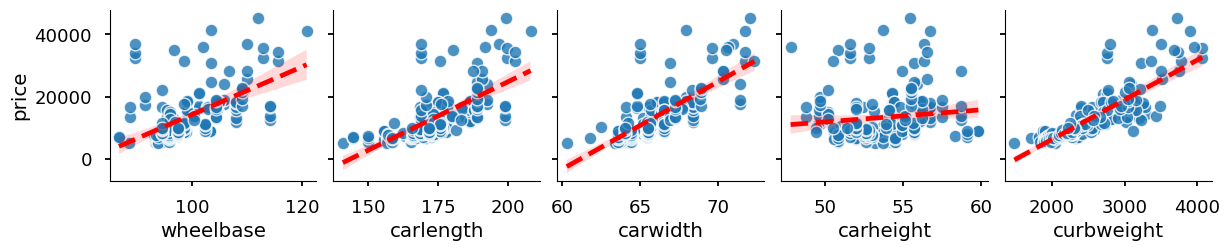

In [6]:
# look at first 5 numeric features
sns.pairplot(df, y_vars='price',kind='reg',x_vars=cols[:5],
             plot_kws=dict(line_kws={'color':'red', 'ls':'--'},
                           scatter_kws={'edgecolor':'white','lw':1}));

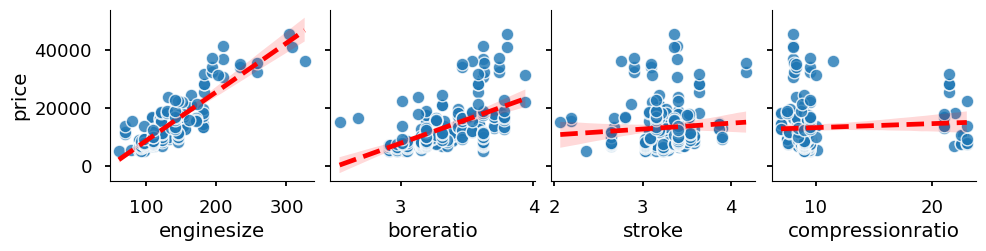

In [7]:
# look at next 4
sns.pairplot(df, y_vars='price',kind='reg',x_vars=cols[5:9],
             plot_kws=dict(line_kws={'color':'red', 'ls':'--'},
                           scatter_kws={'edgecolor':'white','lw':1}));

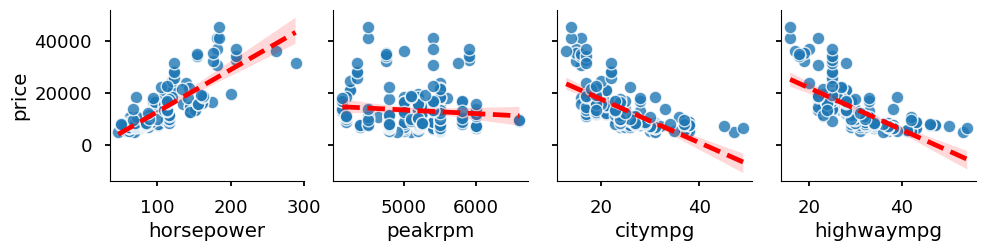

In [8]:
# look at last 4
sns.pairplot(df, y_vars='price',kind='reg',x_vars=cols[9:13],
             plot_kws=dict(line_kws={'color':'red', 'ls':'--'},
                           scatter_kws={'edgecolor':'white','lw':1}));

**Note:** Should consider dropping features that have a large "pink" area on the line of best fit (indicates the model is not sure of the linear relationship).

The features that do not have a clear collinearity with the target are:
- 'carheight'
- 'stroke'
- 'compressionratio'
- 'peakrpm'

We will remove these from the dataset so our data can meet the assumption of linearity.

In [9]:
# drop nonlinear features
df = df.drop(columns = ['carheight', 
                        'stroke', 
                        'compressionratio', 
                        'peakrpm'])

## 2.2 Assumption of Independence (Little-to-No Multicollinearity)

The linear regression model assumes that no features are correlated with each other. Of a pair of features that correlate, the feature with the least amount of a linear relationship with the target should be removed from the data.

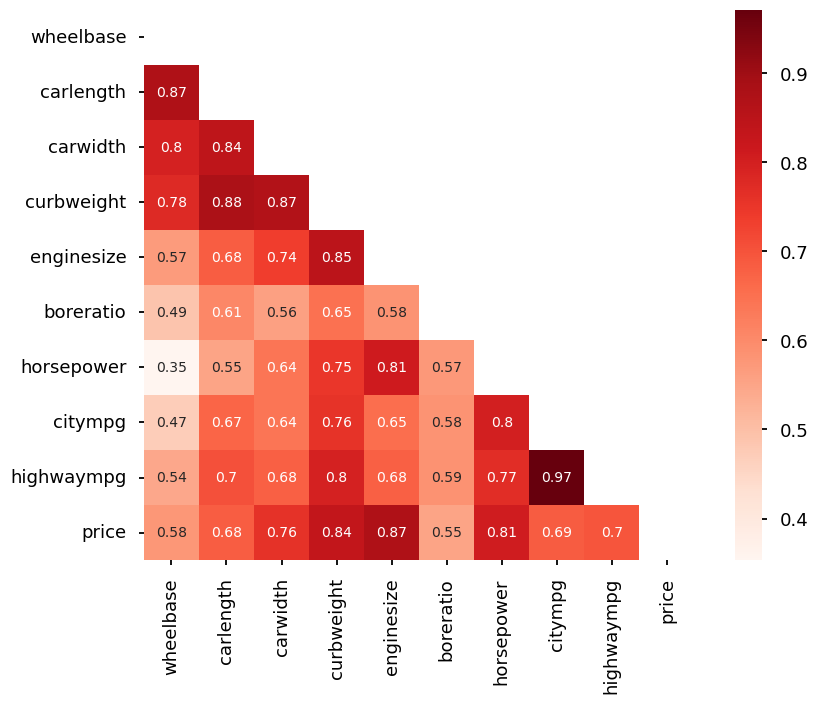

In [10]:
# add target to correlation heatmap to determine which feature
# in each pair can be dropped

# calculate correlations
# keep target
corr = df.drop(columns = ['car_ID']).corr(numeric_only = True).abs()

# mask for easier viewing
mask = np.triu(np.ones_like(corr))

# plot
sns.heatmap(corr,
            square = True, 
            cmap = 'Reds', 
            annot = True, 
            mask = mask);

Correlations between features above 0.8, sorted from highest to lowest collinearity:
1. 'citympg' and 'highwaympg' (0.97)
2. 'curbweight' and 'carlength' (0.88)
3. 'carlength' and 'wheelbase' (0.87)
4. 'curbweight' and 'carwidth' (0.87)
5. 'enginesize' and 'curbweight' (0.85)
6. 'carwidth' and 'carlength' (0.84)
7. 'horsepower' and 'enginesize' (0.81)
8. 'carwidth' and 'wheelbase' (0.80)
9. 'highwaympg' and 'curbweight' (0.80)
10. 'citympg' and 'horsepower' (0.80)

Correlations between features above 0.8 (ones in **bold** will be dropped), with their coefficient of linearity with the target (listed from highest to lowest collinearity):
1. **'citympg' (0.69)** and 'highwaympg' (0.7)
2. **'curbweight' (0.84)** and **'carlength' (0.68)**
3. **'carlength'** and 'wheelbase'
4. **'curbweight' (0.84)** and **'carwidth' (0.76)**
5. 'enginesize' (0.87) and **'curbweight' (0.84)**
6. **'carwidth'** and **'carlength'** 
7. **'horsepower' (0.81)** and 'enginesize' (0.87)
8. **'carwidth'** and 'wheelbase'
9. 'highwaympg' and **'curbweight'**
10. **'citympg'** and **'horsepower'**

The features we will drop are:
- 'citympg'
- 'curbweight'
- 'carlength'
- 'carwidth'
- 'horsepower'


Question: What to do when the variable kept from one pair is the one to be dropped from another pair?

Answer: Start with the HIGHEST collinearity pair (in our correlation heatmap above, that would be 'highwaympg' and 'citympg' with 0.97 correlation). Get rid of the feature with the weakest correlation to the target. Then, if the feature you got rid of appears in another pair, keep the other feature in the pair.

In [11]:
# drop columns showing high correlation with other columns,
# lower correlation with target
df = df.drop(columns = ['citympg', 'curbweight', 'carlength',
                       'carwidth', 'horsepower'])

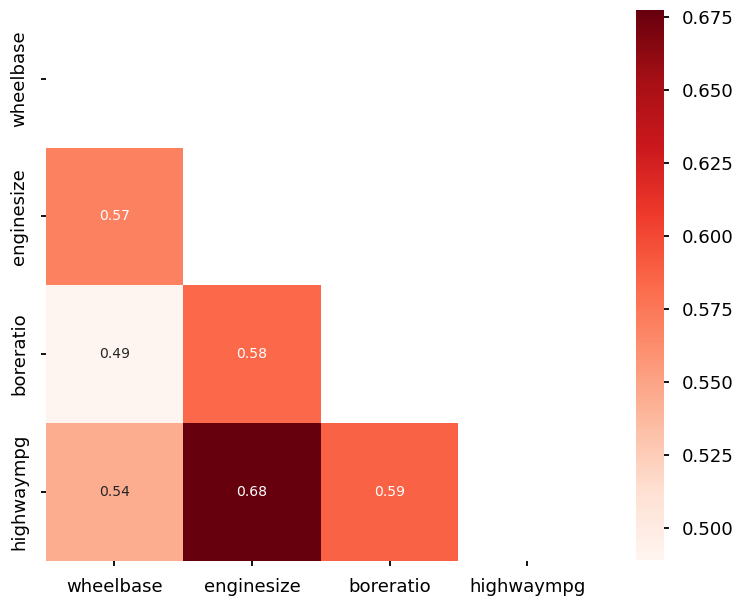

In [12]:
## check
corr = df.drop(columns = ['price', 'car_ID']).corr(numeric_only = True).abs()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, 
            square = True, 
            cmap = 'Reds', 
            annot = True, 
            mask = mask);

There are no remaining correlations above 0.8. We have met the assumption of Little-to-No Collinearity and can move on.

# 3. Initial Preprocessing

In [13]:
# make X and y
y = df['price'].copy()

# for X, will drop 'car_ID' since it is unique to each observation
# will also drop 'CarName'
X = df.drop(columns = ['price', 'car_ID', 'CarName']).copy()

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

# check
X_train.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,highwaympg
17,neutral,gas,std,four,sedan,rwd,front,110.0,ohc,six,209,mpfi,3.62,20
39,neutral,gas,std,four,sedan,fwd,front,96.5,ohc,four,110,1bbl,3.15,33
40,neutral,gas,std,four,sedan,fwd,front,96.5,ohc,four,110,1bbl,3.15,33
47,neutral,gas,std,four,sedan,rwd,front,113.0,dohc,six,258,mpfi,3.63,19
123,safe,gas,std,four,wagon,fwd,front,103.3,ohc,four,122,2bbl,3.35,30


In [14]:
# select categorical columns
cat_select = make_column_selector(dtype_include = 'object')
cat_cols = cat_select(X_train)
cat_cols

['symboling',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem']

In [15]:
# select numerical columns
num_select = make_column_selector(dtype_include = 'number')
num_cols = num_select(X_train)
num_cols

['wheelbase', 'enginesize', 'boreratio', 'highwaympg']

In [16]:
# make categorical pipeline
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', 
                                       sparse=False))

# make numeric pipeline (DON'T SCALE)
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

# make preprocessor (column transformer)
preprocessor = make_column_transformer((cat_pipe,cat_cols),
                                        (num_pipe, num_cols), 
                                       remainder='passthrough')

In [17]:
# fit column transformer on training data ONLY
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['symboling', 'fueltype', 'aspiration',
                                  'doornumber', 'carbody', 'drivewheel',
                                  'enginelocation', 'enginetype',
                                  'cylindernumber', 'fuelsystem']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['wheelbase', 'enginesize', 'boreratio',
                                  'highwaympg'])])

In [18]:
# see transformed X_train as a df
pd.DataFrame(preprocessor.transform(X_train).round(3))

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,110.0,209.0,3.62,20.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,96.5,110.0,3.15,33.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,96.5,110.0,3.15,33.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,113.0,258.0,3.63,19.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,103.3,122.0,3.35,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,109.1,141.0,3.78,28.0
149,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,96.5,110.0,3.15,28.0
150,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,86.6,92.0,2.91,38.0
151,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,95.9,156.0,3.59,24.0


The column names have been lost, so we will get those back.

In [19]:
# create empty list for column names
final_features = []

In [20]:
# categorical column names: in the categorical pipeline
# ('pipeline-1' since we put it first in our preprocessor),
# access the onehotencoder step
ohe_step = preprocessor.named_transformers_['pipeline-1'].named_steps['onehotencoder']

In [21]:
# get feature names out for categorical columns
cat_features = ohe_step.get_feature_names_out(cat_cols)

# check
cat_features

array(['symboling_neutral', 'symboling_riskier', 'symboling_riskiest',
       'symboling_risky', 'symboling_safe', 'symboling_safer',
       'fueltype_diesel', 'fueltype_gas', 'aspiration_std',
       'aspiration_turbo', 'doornumber_four', 'doornumber_two',
       'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd',
       'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_front',
       'enginetype_dohc', 'enginetype_dohcv', 'enginetype_l',
       'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_eight', 'cylindernumber_five',
       'cylindernumber_four', 'cylindernumber_six',
       'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two', 'fuelsystem_1bbl', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi'],
      dtype=object)

In [22]:
# add categorical column names to final_features
final_features.extend(cat_features)

# check
final_features

['symboling_neutral',
 'symboling_riskier',
 'symboling_riskiest',
 'symboling_risky',
 'symboling_safe',
 'symboling_safer',
 'fueltype_diesel',
 'fueltype_gas',
 'aspiration_std',
 'aspiration_turbo',
 'doornumber_four',
 'doornumber_two',
 'carbody_convertible',
 'carbody_hardtop',
 'carbody_hatchback',
 'carbody_sedan',
 'carbody_wagon',
 'drivewheel_4wd',
 'drivewheel_fwd',
 'drivewheel_rwd',
 'enginelocation_front',
 'enginetype_dohc',
 'enginetype_dohcv',
 'enginetype_l',
 'enginetype_ohc',
 'enginetype_ohcf',
 'enginetype_ohcv',
 'enginetype_rotor',
 'cylindernumber_eight',
 'cylindernumber_five',
 'cylindernumber_four',
 'cylindernumber_six',
 'cylindernumber_three',
 'cylindernumber_twelve',
 'cylindernumber_two',
 'fuelsystem_1bbl',
 'fuelsystem_2bbl',
 'fuelsystem_4bbl',
 'fuelsystem_idi',
 'fuelsystem_mfi',
 'fuelsystem_mpfi',
 'fuelsystem_spdi',
 'fuelsystem_spfi']

In [23]:
# add list of numeric features to final_features
final_features.extend(num_cols)

# check
final_features

['symboling_neutral',
 'symboling_riskier',
 'symboling_riskiest',
 'symboling_risky',
 'symboling_safe',
 'symboling_safer',
 'fueltype_diesel',
 'fueltype_gas',
 'aspiration_std',
 'aspiration_turbo',
 'doornumber_four',
 'doornumber_two',
 'carbody_convertible',
 'carbody_hardtop',
 'carbody_hatchback',
 'carbody_sedan',
 'carbody_wagon',
 'drivewheel_4wd',
 'drivewheel_fwd',
 'drivewheel_rwd',
 'enginelocation_front',
 'enginetype_dohc',
 'enginetype_dohcv',
 'enginetype_l',
 'enginetype_ohc',
 'enginetype_ohcf',
 'enginetype_ohcv',
 'enginetype_rotor',
 'cylindernumber_eight',
 'cylindernumber_five',
 'cylindernumber_four',
 'cylindernumber_six',
 'cylindernumber_three',
 'cylindernumber_twelve',
 'cylindernumber_two',
 'fuelsystem_1bbl',
 'fuelsystem_2bbl',
 'fuelsystem_4bbl',
 'fuelsystem_idi',
 'fuelsystem_mfi',
 'fuelsystem_mpfi',
 'fuelsystem_spdi',
 'fuelsystem_spfi',
 'wheelbase',
 'enginesize',
 'boreratio',
 'highwaympg']

In [24]:
# transform X_train again, this time with final_features
# as column names; keep X_train.index as index
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         columns = final_features,
                         index = X_train.index)

# check
X_train_df.head()

,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,wheelbase,enginesize,boreratio,highwaympg
17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,110.0,209.0,3.62,20.0
39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,96.5,110.0,3.15,33.0
40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,96.5,110.0,3.15,33.0
47,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,113.0,258.0,3.63,19.0
123,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,103.3,122.0,3.35,30.0


In [25]:
# transform X_test
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        columns = final_features,
                        index = X_test.index)

# check
X_test_df.head()

,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,wheelbase,enginesize,boreratio,highwaympg
48,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,113.0,258.0,3.63,19.0
196,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,104.3,141.0,3.78,28.0
148,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,96.9,108.0,3.62,29.0
53,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93.1,91.0,3.03,38.0
99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,97.2,120.0,3.33,34.0


# 4. Preprocessing for statsmodels

In [26]:
# add constant column for statsmodels
# confirm expected results before overwriting variables
# prepend = False puts constant column at end of df
sm.add_constant(X_train_df, prepend=False, has_constant='add').head()

,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,wheelbase,enginesize,boreratio,highwaympg,const
17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,110.0,209.0,3.62,20.0,1.0
39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,96.5,110.0,3.15,33.0,1.0
40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,96.5,110.0,3.15,33.0,1.0
47,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,113.0,258.0,3.63,19.0,1.0
123,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,103.3,122.0,3.35,30.0,1.0


In [27]:
# overwrite X_train and X_test
X_train_df = sm.add_constant(X_train_df, 
                             has_constant = 'add', 
                             prepend = False)
X_test_df = sm.add_constant(X_test_df, 
                            has_constant = 'add',
                            prepend = False)

# check
display(X_train_df.head(2), X_test_df.head(2))

,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,wheelbase,enginesize,boreratio,highwaympg,const
17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,110.0,209.0,3.62,20.0,1.0
39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,96.5,110.0,3.15,33.0,1.0


,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,wheelbase,enginesize,boreratio,highwaympg,const
48,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,113.0,258.0,3.63,19.0,1.0
196,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,104.3,141.0,3.78,28.0,1.0


# 5. statsmodels Model with Result Summary

In [28]:
# instantiate sm.OLS model with training data
# y goes first, then X
# hasconst = Ture is default; showing for practice
model = sm.OLS(y_train, X_train_df, hasconst = True)

In [29]:
# fit and save result in variable
result = model.fit()

In [30]:
# see model performance metrics (on training data)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     30.09
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           9.17e-44
Time:                        12:28:44   Log-Likelihood:                -1409.6
No. Observations:                 153   AIC:                             2891.
Df Residuals:                     117   BIC:                             3000.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
symboling_neutral        54.1781    757.958      0.071      0.943   -1446.918    1555.274
symboling_riskier      -468.0864    793.322     -0.590      0.556   -2039.219    1103.046
symboling_riskiest      427.5036   1040.965      0.411      0.682   -1634.073    2489.080
symboling_risky         -32.9900    723.838     -0.046      0.964   -1466.514    1400.533
symboling_safe        -2032.4630   1118.054     -1.818      0.072   -4246.709     181.783
symboling_safer       -3530.6769   1914.275     -1.844      0.068   -7321.798     260.444
fueltype_diesel       -1661.7389   1245.444     -1.334      0.185   -4128.275     804.798
fueltype_gas          -3920.7959   1634.927     -2.398      0.018   -7158.683    -682.909
aspiration_std        -4153.5499   1438.934     -2.887      0.005   -7003.283   -1303.817
aspiration_turbo      -1428.9848   1439.375     -0.993      0.323   -4279.592    1421.623
doornumber_four       -3044.9370   1508.781     -2.018      0.046   -6032.998     -56.876
doornumber_two        -2537.5977   1362.453     -1.863      0.065   -5235.865     160.670
carbody_convertible    2229.0156   1541.124      1.446      0.151    -823.099    5281.130
carbody_hardtop       -2491.1798   1430.445     -1.742      0.084   -5324.100     341.741
carbody_hatchback     -2266.1398    938.887     -2.414      0.017   -4125.556    -406.723
carbody_sedan          -868.5029    976.903     -0.889      0.376   -2803.207    1066.202
carbody_wagon         -2185.7279   1143.106     -1.912      0.058   -4449.589      78.133
drivewheel_4wd        -2029.6051   1174.589     -1.728      0.087   -4355.818     296.608
drivewheel_fwd        -2616.6689   1092.955     -2.394      0.018   -4781.208    -452.130
drivewheel_rwd         -936.2608   1367.343     -0.685      0.495   -3644.212    1771.690
enginelocation_front  -5582.5347   2737.947     -2.039      0.044    -1.1e+04    -160.175
enginetype_dohc        -171.7802   1340.543     -0.128      0.898   -2826.656    2483.096
enginetype_dohcv      -1014.3568   3657.140     -0.277      0.782   -8257.132    6228.418
enginetype_l          -3344.2251   2079.507     -1.608      0.110   -7462.579     774.129
enginetype_ohc         2380.4513   1210.259      1.967      0.052     -16.404    4777.306
enginetype_ohcf         296.9312   1490.944      0.199      0.842   -2655.806    3249.668
enginetype_ohcv       -3757.6840   1382.393     -2.718      0.008   -6495.441   -1019.927
enginetype_rotor         28.1287   1712.748      0.016      0.987   -3363.879    3420.137
cylindernumber_eight   6246.5918   2779.827      2.247      0.027     741.290    1.18e+04
cylindernumber_five   -4937.8857   1887.112     -2.617      0.010   -8675.213   -1200.559
cylindernumber_four   -8020.8522   2049.835     -3.913      0.000   -1.21e+04   -3961.262
cylindernumber_six    -

# 6. Evaluate Model on Test Data

In [31]:
# use result variable to predict target for test data
test_preds = result.predict(X_test_df)

In [32]:
# evaluate test metrics
print(f'Test R2: {r2_score(y_test, test_preds):.5f}')
print(f'Test MSE: {mean_squared_error(y_test, test_preds):.5f}')

Test R2: 0.89761
Test MSE: 7832872.43025


# 7. Model Assumptions (Part 2)

**Assumption of Normality:** The linear regression model assumes that the residuals (differences between predictions and actual values) is normally distributed.

**Assumption of Homoscedasticity:** The linear model assumes that the residuals have approximately equal variance across the full range of predictions.

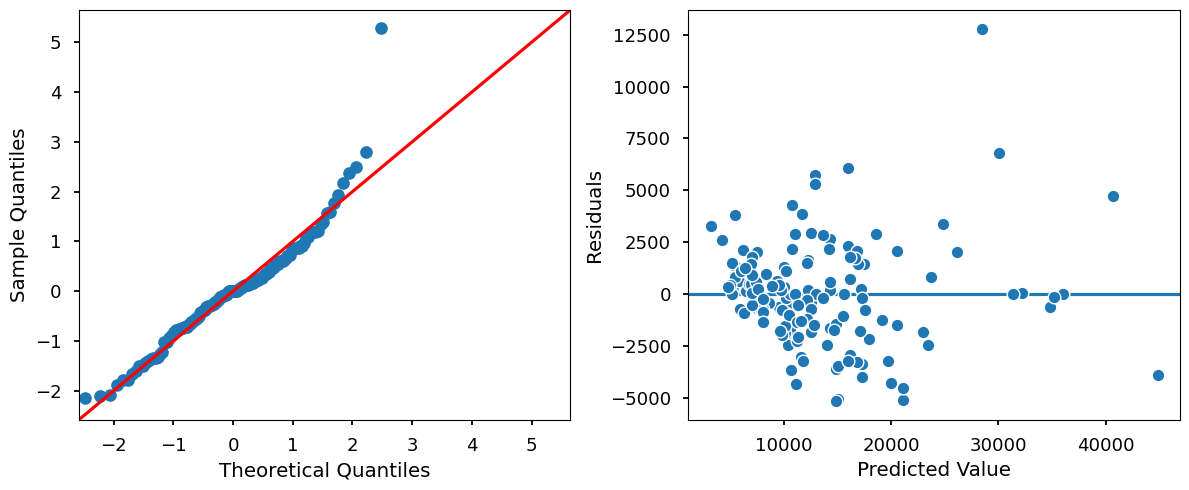

In [33]:
# define helper function to plot qqplot and residual plot
# code from Coding Dojo Learn Platform
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    
evaluate_ols(result,X_train_df, y_train)

The Q-Q Plot shows that our residuals generally follow the assumption of normality, except especially for one observation (on the very right of the plot). This is an outlier that we will take out of the data.

The residual plot shows that our residuals are fairly equally spread out across all predicted values. There is one clear outlier, which will be taken out of the data.

# 8. Iterating on the Model

## 8.1 Remove Outliers

Here we will identify and drop outliers to improve our model.

In [34]:
# instantiate scaler to calculate z-scores
scaler = StandardScaler()
z_price = scaler.fit_transform(y_train.values.reshape(-1, 1))

# check
z_price

array([[ 3.10591049],
       [-0.54747299],
       [-0.35851611],
       [ 2.50255164],
       [-0.53756904],
       [ 0.69039003],
       [-0.97399427],
       [-0.7228771 ],
       [-0.86909063],
       [-0.30599913],
       [-0.82804137],
       [-1.02312306],
       [ 0.10605718],
       [-0.23432583],
       [-0.74946137],
       [-0.59256201],
       [ 0.76545152],
       [ 0.7817409 ],
       [-0.39852284],
       [-0.39761064],
       [ 0.69755736],
       [ 1.16916766],
       [ 0.02004922],
       [ 0.72635699],
       [-0.0543607 ],
       [-0.49091624],
       [-0.97399427],
       [-0.31942159],
       [-0.45716463],
       [-0.70854244],
       [ 0.50547292],
       [ 0.18802537],
       [-0.40217167],
       [-0.85462565],
       [-0.35200036],
       [-0.66319279],
       [-0.11417532],
       [ 0.6651089 ],
       [ 2.75458101],
       [ 0.04806696],
       [-0.53405054],
       [-0.40230198],
       [ 0.38467083],
       [-0.62657425],
       [ 0.17629701],
       [-1

In [35]:
# save outliers with indices
z_price = pd.Series(z_price.flatten(), index = y_train.index)

# check
z_price

17     3.105910
39    -0.547473
40    -0.358516
47     2.502552
123   -0.537569
         ...   
200    0.495048
41    -0.013181
31    -0.806800
124   -0.036768
26    -0.708542
Length: 153, dtype: float64

In [36]:
# create boolean mask for outliers
# outliers defined as more than 3 std from mean
idx_outliers = z_price > 3

# check
idx_outliers

17      True
39     False
40     False
47     False
123    False
       ...  
200    False
41     False
31     False
124    False
26     False
Length: 153, dtype: bool

In [37]:
# how many outliers? (out of 205 observations)
idx_outliers.sum()

4

In [38]:
# save a clean version of y_train and X_train with outliers removed
y_train_cln = y_train[~idx_outliers]
X_train_cln = X_train_df[~idx_outliers]

# check
print(len(y_train), len(y_train_cln), len(X_train_df), len(X_train_cln))

153 149 153 149


In [39]:
# calculate range of prices of cars now in our dataframe
# this gives our stakeholders an expectation of the types
# of cars our model can predict prices for
print(f"Our model includes cars priced:")
print(f"- Greater than ${y_train_cln.min():,.2f}")
print(f"- Less than ${y_train_cln.max():,.2f}")

Our model includes cars priced:
- Greater than $5,118.00
- Less than $36,000.00


In [40]:
# remove outliers from test data
z_price_test = scaler.transform(y_test.values.reshape(-1, 1))
z_price_test = pd.Series(z_price_test.flatten(), index = y_test.index )
idx_outliers_test = z_price_test > 3

In [41]:
# how many outliers in test data?
idx_outliers_test.sum()

1

In [42]:
# make clean version of X_test and y_test
y_test_cln = y_test[~idx_outliers_test]
X_test_cln = X_test_df[~idx_outliers_test]

# check
print(len(y_test), len(y_test_cln), len(X_test_df), len(X_test_cln))

52 51 52 51


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     31.33
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           1.36e-43
Time:                        12:28:45   Log-Likelihood:                -1336.0
No. Observations:                 149   AIC:                             2744.
Df Residuals:                     113   BIC:                             2852.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
symboling_neutral      -515.23

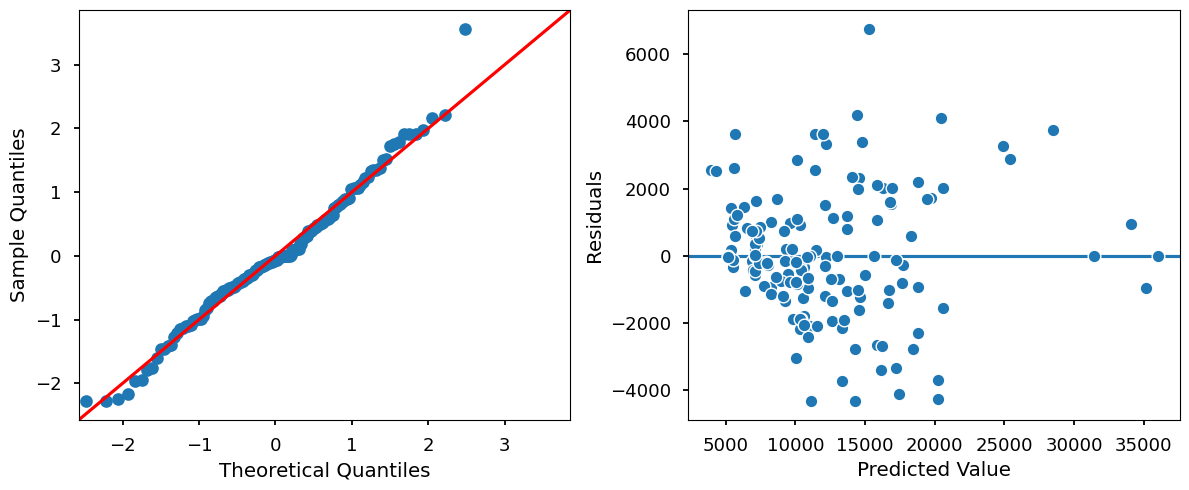

In [43]:
# look at new model with outliers removed
model = sm.OLS(y_train_cln, X_train_cln)
result = model.fit()

print(result.summary())
evaluate_ols(result, X_train_cln, y_train_cln)

This Q-Q Plot and Residual Plot look better than previously.

## 8.2 Remove Columns with Insignificant P-Values

In [44]:
# save p-values
p_vals = result.pvalues

# filter for p-values that are > 0.05
p_vals[p_vals > 0.05]

symboling_neutral        0.393615
symboling_riskier        0.536513
symboling_riskiest       0.108929
symboling_risky          0.485637
fueltype_diesel          0.050312
aspiration_turbo         0.163650
carbody_convertible      0.134633
carbody_sedan            0.165712
drivewheel_rwd           0.604059
enginetype_dohc          0.865779
enginetype_dohcv         0.445231
enginetype_ohc           0.607522
enginetype_ohcf          0.419093
enginetype_ohcv          0.338500
enginetype_rotor         0.328304
cylindernumber_three     0.540264
cylindernumber_twelve    0.231446
cylindernumber_two       0.328304
fuelsystem_1bbl          0.142834
fuelsystem_2bbl          0.944469
fuelsystem_4bbl          0.335117
fuelsystem_idi           0.050312
fuelsystem_mfi           0.261354
fuelsystem_mpfi          0.293116
fuelsystem_spdi          0.089437
fuelsystem_spfi          0.988004
boreratio                0.544298
highwaympg               0.716023
dtype: float64

In [45]:
# check the value counts of categorical variables
print("symboling:\n", df['symboling'].value_counts(), "\n")
print("fueltype:\n", df['fueltype'].value_counts(), "\n")
print("aspiration:\n", df['aspiration'].value_counts(), "\n")
print("carbody:\n", df['carbody'].value_counts(), "\n")
print("drivewheel:\n", df['drivewheel'].value_counts(), "\n")
print("enginetype:\n", df['enginetype'].value_counts(), "\n")
print("cylindernumber:\n", df['cylindernumber'].value_counts(), "\n")
print("fuelsystem:\n", df['fuelsystem'].value_counts())

symboling:
 neutral     67
risky       54
riskier     32
riskiest    27
safe        22
safer        3
Name: symboling, dtype: int64 

fueltype:
 gas       185
diesel     20
Name: fueltype, dtype: int64 

aspiration:
 std      168
turbo     37
Name: aspiration, dtype: int64 

carbody:
 sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: carbody, dtype: int64 

drivewheel:
 fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64 

enginetype:
 ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv      1
Name: enginetype, dtype: int64 

cylindernumber:
 four      159
six        24
five       11
eight       5
two         4
three       1
twelve      1
Name: cylindernumber, dtype: int64 

fuelsystem:
 mpfi    94
2bbl    66
idi     20
1bbl    11
spdi     9
4bbl     3
mfi      1
spfi     1
Name: fuelsystem, dtype: int64


In [46]:
# # alternate way to see how many values are in a categorical
# # column:
# category_cols = [col for col in X_train_df.columns if col.startswith('category')]

# # confirm by printing first few values
# category_cols[:3]

# # get number of values for that category
# len(category_cols)

# # how many of those values are insignificant?
# len(p_vals[p_vals > 0.05].startswith('category'))

symboling: Since there are 6 symboling values and 4 of them have insignificant p-values, we will get rid of the symboling feature.

carbody: Two out of five car body types were insignificant, so we will keep this feature.

fueltype: 1 out of 2 were insignificant; we will drop this.

aspiration: 1 out of 2 were insignificant; we will drop this.

drivewheel: 1 out of 3 were insignificant; we will keep this.

enginetype: 6 out of 7 were insignificant; we will drop this.

cylindernumber: 3 out of 7 were insignificant; we will keep this.

fuelsystem: 8 out of 8 were insignificant; we will drop this.

In summary, we will drop the following features due to a majority of values having an insignificant p-value:
- fueltype
- aspiration
- enginetype
- fuelsystem

In [47]:
# make list of column names
words_to_drop = ['fueltype', 'aspiration', 'enginetype', 'fuelsystem']

# make list of columns to drop using words_to_drop
columns_to_drop = [col for col in X_train_cln.columns if any(col.startswith(word) for word in words_to_drop)]

# drop columns from training data
X_train_cln = X_train_cln.drop(columns = columns_to_drop)

# check
X_train_cln.columns

Index(['symboling_neutral', 'symboling_riskier', 'symboling_riskiest',
       'symboling_risky', 'symboling_safe', 'symboling_safer',
       'doornumber_four', 'doornumber_two', 'carbody_convertible',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_4wd', 'drivewheel_fwd', 'drivewheel_rwd',
       'enginelocation_front', 'cylindernumber_eight', 'cylindernumber_five',
       'cylindernumber_four', 'cylindernumber_six', 'cylindernumber_three',
       'cylindernumber_twelve', 'cylindernumber_two', 'wheelbase',
       'enginesize', 'boreratio', 'highwaympg', 'const'],
      dtype='object')

In [48]:
# somehow this code cell adds a row to X_test_cln
# but it shouldn't

# remove columns from the test data
X_test_cln = X_test_cln.drop(columns = columns_to_drop)

# check
X_test_cln.columns

Index(['symboling_neutral', 'symboling_riskier', 'symboling_riskiest',
       'symboling_risky', 'symboling_safe', 'symboling_safer',
       'doornumber_four', 'doornumber_two', 'carbody_convertible',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_4wd', 'drivewheel_fwd', 'drivewheel_rwd',
       'enginelocation_front', 'cylindernumber_eight', 'cylindernumber_five',
       'cylindernumber_four', 'cylindernumber_six', 'cylindernumber_three',
       'cylindernumber_twelve', 'cylindernumber_two', 'wheelbase',
       'enginesize', 'boreratio', 'highwaympg', 'const'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     37.38
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           9.05e-45
Time:                        12:28:45   Log-Likelihood:                -1362.2
No. Observations:                 149   AIC:                             2770.
Df Residuals:                     126   BIC:                             2840.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
symboling_neutral     -1065.95

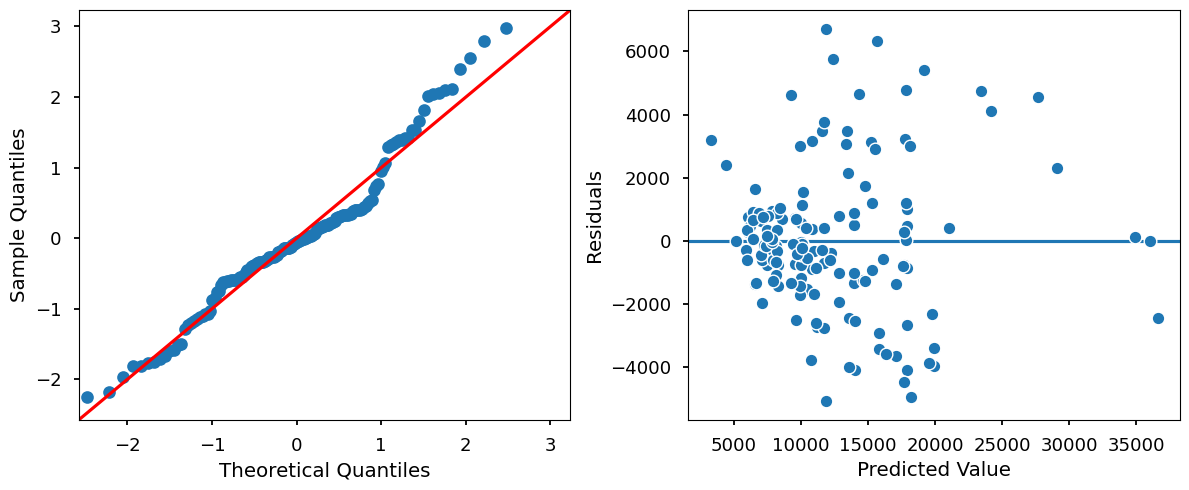

In [49]:
# look at new model with insignificant p-value columns removed
model = sm.OLS(y_train_cln, X_train_cln)
result = model.fit()
print(result.summary())
evaluate_ols(result, X_train_cln, y_train_cln)

# 9. Evaluate Model on Test Data

In [50]:
# instantiate sm.OLS model with training data
# y goes first, then X
# hasconst = Ture is default; showing for practice
model = sm.OLS(y_train_cln, X_train_cln, hasconst = True)

In [51]:
# fit and save result in variable
result = model.fit()

In [52]:
# see model performance metrics (on training data)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     37.38
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           9.05e-45
Time:                        12:28:46   Log-Likelihood:                -1362.2
No. Observations:                 149   AIC:                             2770.
Df Residuals:                     126   BIC:                             2840.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
symboling_neutral     -1065.9532    695.897     -1.532      0.128   -2443.113     311.206
symboling_riskier      -807.1267    690.390     -1.169      0.245   -2173.389     559.136
symboling_riskiest     1020.0008    871.616      1.170      0.244    -704.902    2744.903
symboling_risky        -786.4760    638.582     -1.232      0.220   -2050.212     477.260
symboling_safe        -1117.4820    906.507     -1.233      0.220   -2911.433     676.469
symboling_safer       -1727.5756   1619.811     -1.067      0.288   -4933.133    1477.982
doornumber_four       -2065.4285   1373.355     -1.504      0.135   -4783.258     652.401
doornumber_two        -2419.1842   1235.622     -1.958      0.052   -4864.445      26.076
carbody_convertible     845.2978   1271.937      0.665      0.508   -1671.827    3362.423
carbody_hardtop       -1709.7186   1309.700     -1.305      0.194   -4301.577     882.140
carbody_hatchback     -1265.0908    771.825     -1.639      0.104   -2792.511     262.329
carbody_sedan          -270.6436    842.809     -0.321      0.749   -1938.538    1397.251
carbody_wagon         -2084.4575   1025.540     -2.033      0.044   -4113.971     -54.944
drivewheel_4wd        -1358.4750    997.981     -1.361      0.176   -3333.451     616.501
drivewheel_fwd        -2745.2444    920.478     -2.982      0.003   -4566.844    -923.644
drivewheel_rwd         -380.8933   1224.909     -0.311      0.756   -2804.953    2043.167
enginelocation_front  -4484.6127   2491.636     -1.800      0.074   -9415.487     446.261
cylindernumber_eight   5978.0570   1738.779      3.438      0.001    2537.065    9419.049
cylindernumber_five     291.2323   1249.327      0.233      0.816   -2181.150    2763.615
cylindernumber_four   -5120.8997   1179.265     -4.342      0.000   -7454.630   -2787.169
cylindernumber_six    -3912.9159    940.757     -4.159      0.000   -5774.646   -2051.185
cylindernumber_three  -1821.6784   2760.556     -0.660      0.511   -7284.737    3641.380
cylindernumber_twelve  3082.9263   3773.215      0.817      0.415   -4384.155    1.06e+04
cylindernumber_two    -2981.3343   2426.921     -1.228      0.222   -7784.140    1821.472
wheelbase               240.9152     76.379      3.154      0.002      89.763     392.068
enginesize               62.3996     19.913      3.134      0.002      22.992     101.807
boreratio               661.6775   1398.802      0.473      0.637   -2106.510    3429.865
highwaympg              -72.6454     51.932     -1.399      0.164    -175.417      30.126
const                 -4484.6127   2491.636     -1.800      0.074   -9415.487     446.261
==============================================================================
Omnibus:                        7.610   Durbin-Watson:                   2.342
Prob(Omnibus):                  0.022   Jarqu

R-Squared for Test Data: 0.83


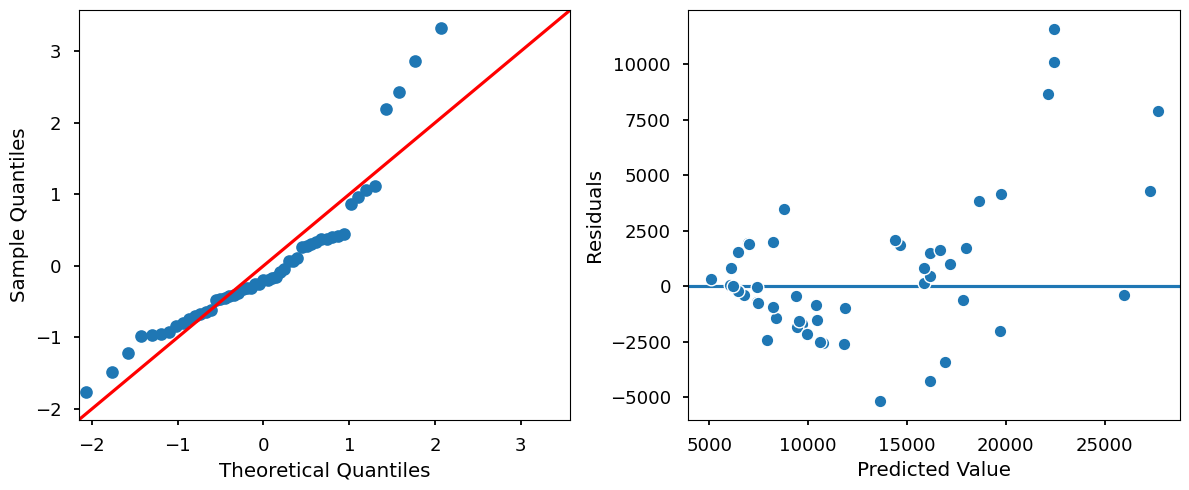

In [53]:
# use result variable to predict target for test data
test_preds = result.predict(X_test_cln)

# evaluate test data with r2 score
r2_test = r2_score(y_test_cln, result.predict(X_test_cln))

print(f"R-Squared for Test Data: {r2_test:.2f}")
evaluate_ols(result, X_test_cln, y_test_cln)

It looks like there are still some outliers that should be removed, as they are far off the normal distribution in the Q-Q Plot. The Residuals Plot also still shows a slightly conical shape. The data should be iterated over again to see if this can be improved.

# 10. Save Model

In [54]:
# create a dictionary of all of the variables
export = {'X_train': X_train_cln,
         'y_train': y_train_cln,
         'X_test': X_test_cln,
         'y_test': y_test_cln,
         'Outlier Scaler': scaler,
         'Column Transformer': preprocessor,
         'OLS Results': result}

# dump dictionary with joblib
joblib.dump(export, 'ols_results.joblib')

['ols_results.joblib']

In [55]:
# code for loading a joblib
loaded_data = joblib.load('ols_results.joblib')
loaded_data.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'Outlier Scaler', 'Column Transformer', 'OLS Results'])